<a href="https://colab.research.google.com/github/egorssed/VAE_on_HST_galaxies/blob/main/Filtering_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from tqdm import tqdm
drive.mount('/content/drive')
Folder='/content/drive/My Drive/AstroLensing'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
galaxies=np.load(Folder+'/DataSet/Full_Data/Dataset_images.npy')
df=pd.read_csv(Folder+'/DataSet/Full_Data/Dataset_labels_original.csv',index_col=0)
print(galaxies.shape)
print(df.shape)
df.head(1)

(50930, 64, 64)
(50930, 18)


,COSMOS_noise_sigma,IDENT,Manual_noise_sigma,Original_size,bulgefit,fit_dvc_btt,fit_mad_b,fit_mad_s,fit_status,flux,flux_radius,hlr,mag_auto,maxI_4_CV,sersicfit,use_bulgefit,viable_sersic,zphot
0,0.00255,141190,0.00871,242,[1.20382532e-02 4.15108632e+01 1.00000000e+00 ...,0.072256,0.00285,0.002923,[1 1 1 1 1],99.84127,27.871679,[0.70258482 0. 0. ],21.040642,0.441848,[1.33632217e-02 4.13907911e+01 1.14539305e+00 ...,0,1,0.195


# Labels prettifying

In [ ]:
image_size=64
Sersic_columns=['I','HLR','n','q','boxiness','x0','y0','phi']
String_parameters=['bulgefit','sersicfit','hlr','fit_status']

def split_arrays_into_features(series):
    result=series.copy()
    for column in String_parameters:
        #Represent '[1 2 \n 3]' as [1,2,3]
        result[column]=[float(x) for x in result[column][1:-1].split()]
    for i,parameter in enumerate(Sersic_columns):
        result['Sersic'+'_'+parameter]=result['sersicfit'][i]
    for i,parameter in enumerate(Sersic_columns):
        result['Bulge'+'_'+parameter]=result['bulgefit'][i]
    for i,parameter in enumerate(Sersic_columns):
        result['Disk'+'_'+parameter]=result['bulgefit'][8+i]
    
    result['HLRcirc'+'_'+'Sersic']=result['hlr'][0]
    result['HLRcirc'+'_'+'Bulge']=result['hlr'][1]
    result['HLRcirc'+'_'+'Disk']=result['hlr'][2]
    
    for i in range(5):
        result['fit_status_'+str(i)]=result['fit_status'][i]
        
    #Images are centered anyway and x0/2,y0/2 just points on image center
    Mask_center=result.index.str.endswith('x0') | result.index.str.endswith('y0')
    result=result[np.logical_not(Mask_center)]
    
    #Arcsecs to pixels
    Mask_arcsec_expressed=result.index.str.startswith('HLR')
    result[Mask_arcsec_expressed]=result[Mask_arcsec_expressed]/0.03
    
    #Original_shape=Image_shape-2 when you work with gal
    #We used its scaling Original_shape/(desired_shape-2) which seems sensible
    #We actually bring image with size (Original_size+2) to 64. 
    #Therefore we scale length in pixels by this factor
    Mask_pixel_expressed=result.index.str.endswith('HLR')| result.index.str.startswith('flux_radius') | Mask_arcsec_expressed
    result[Mask_pixel_expressed]=result[Mask_pixel_expressed]*image_size/(result['Original_size']+2)
    
    
    result=result.drop(String_parameters)
    return result

In [ ]:
tqdm.pandas()
df_new=df.progress_apply(split_arrays_into_features,axis=1)

Streaming output truncated to the last 5000 lines.

 83%|████████▎ | 42475/50930 [23:36<05:16, 26.69it/s]

 83%|████████▎ | 42478/50930 [23:36<05:13, 26.93it/s]

 83%|████████▎ | 42481/50930 [23:36<05:14, 26.88it/s]

 83%|████████▎ | 42484/50930 [23:36<05:10, 27.21it/s]

 83%|████████▎ | 42487/50930 [23:36<05:06, 27.54it/s]

 83%|████████▎ | 42490/50930 [23:36<05:24, 26.03it/s]

 83%|████████▎ | 42493/50930 [23:36<05:12, 26.99it/s]

 83%|████████▎ | 42496/50930 [23:36<05:05, 27.61it/s]

 83%|████████▎ | 42499/50930 [23:37<05:05, 27.62it/s]

 83%|████████▎ | 42502/50930 [23:37<05:00, 28.01it/s]

 83%|████████▎ | 42505/50930 [23:37<04:59, 28.17it/s]

 83%|████████▎ | 42508/50930 [23:37<05:01, 27.94it/s]

 83%|████████▎ | 42511/50930 [23:37<04:58, 28.21it/s]

 83%|████████▎ | 42514/50930 [23:37<05:11, 27.02it/s]

 83%|████████▎ | 42517/50930 [23:37<05:10, 27.10it/s]

 83%|████████▎ | 42520/50930 [23:37<05:09, 27.21it/s]

 83%|████████▎ | 42523/50930 [23:37<05:07, 27.34it/s]

 83%|████████

In [43]:
df_new['minI']=galaxies.min(axis=(1,2))
df_new['maxI']=galaxies.max(axis=(1,2))
df_new['SNR_Manual']=df_new.maxI_4_CV/df_new.Manual_noise_sigma

In [44]:
#df_new.to_csv(Folder+'/DataSet/Full_Data/Dataset_labels_splitted.csv')

# Labels Filtering

In [47]:
df=pd.read_csv(Folder+'/DataSet/Full_Data/Dataset_labels_splitted.csv',index_col=0)

In [48]:
mask_SNR=(df.SNR_Manual>20) & (df.SNR_Manual<100)
#HLR of 4 should exclude most of dot-like galaxies
#HLR>32 is irrelevant since image size is 64
mask_Sersic_HLR=(df.Sersic_HLR>4) & (df.Sersic_HLR<32)
# Most of the galaxies with upper bound of n=6 and close to it are dot-like. Let's work with n<5.99 .
mask_Sersic_n=(df.Sersic_n<5.99)

nonunifomity=np.zeros(len(galaxies))
for i,image in enumerate(galaxies):
    nonunifomity[i]=galaxies[i].max()/galaxies[i].mean()
df['NonUniformity']=nonunifomity
mask_Uniform=df.NonUniformity<100

In [51]:
df_filtered=df[mask_SNR & mask_Sersic_HLR & mask_Sersic_n & mask_Uniform]
Filtered_galaxies=galaxies[df_filtered.index]

df_filtered.reset_index().drop('index',axis=1).to_csv(Folder+'/DataSet/Filtered_Data/Dataset_labels_filtered.csv')
np.save(Folder+'/DataSet/Filtered_Data/Images_filtered.csv',Filtered_galaxies)
print('Number of galaxies: ',len(df_filtered))

Number of galaxies:  22515


# Dataset overview

## Functions

In [52]:
def Show_stats(images,df,column,min_value=-1,max_value=-1):
    #Convenient function to observe impact of feature on image
    #For a given limited feature shows histogram of this feature, best and worst galaxy images
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    if min_value==-1:
        min_value=df[column].values.min()
    if max_value==-1:
        max_value=df[column].values.max()
    
    #Extract galaxies according to feature limits
    df_filt=df[(df[column].values>=min_value) & (df[column].values<=max_value)]
    min_mask=df_filt[column]==df_filt[column].min()
    max_mask=df_filt[column]==df_filt[column].max()
    plt.hist(df_filt[column],bins=100)
    plt.title(column+' histogram')
    
    #Number of galaxies left for given limits
    print(df_filt.shape[0], 'Galaxies')
    print((column + ' [{:.2f},{:.2f}]').format(min_value,max_value))
    
    #Images of best and worst galaxies in terms of the given feature
    i=(df_filt[min_mask].index)[0]
    image=galaxies[i]
    plt.subplot(132)
    plt.title(column+'={:.2f}'.format(df_filt[column].min()))
    plt.imshow(image,cmap='gray_r')
    plt.colorbar()
    plt.axis('off')
    
    i=(df_filt[max_mask].index)[0]
    image=galaxies[i]
    plt.subplot(133)
    plt.title(column+'={:.2f}'.format(df_filt[column].max()))
    plt.imshow(image,cmap='gray_r')
    plt.colorbar()
    plt.axis('off')

def plt_Galaxy_from_df_i(df,i):
    #Plot galaxy and its features by index in the dataframe
    index=df.iloc[i].name
    print('SNR_max SNR_mean Sigma_x Sigma_y Uniform')
    print(df.iloc[i][2],df.iloc[i][-2],df.iloc[i][-4],df.iloc[i][-3],df.iloc[i][-1])
    plt.imshow(galaxies[index],cmap='gray_r')
    print('index',index)
    plt.axis('off')
    plt.show()
    

def Show_100(df):
    #Show images of 100 first galaxies in the dataframe
    #It is useful if dataframe is sorted in a proper way
    plt.figure(figsize=(20,20))
    gal_to_see=galaxies[df.index[:100].astype(int)]
    for i in range(len(gal_to_see)):
        x=i//10
        y=np.mod(i,10)
        ax = plt.subplot2grid((10,10), (x,y))
        ax.imshow(gal_to_see[i],cmap='gray_r')
        #,cmap='gray_r'
        ax.axis('off')
    plt.show()

def Filt_df(df,Mask=[],Sort_key=None,Sort_type=None):
    if len(Mask)>0:
        res=df[Mask]
    else:
        res=df
    
    if Sort_key:
        return res.sort_values(by=Sort_key,ascending=Sort_type)
    else:
        return res
def Mean_Sigma(df):
    return np.sqrt((df.Gauss_sigma_x**2+df.Gauss_sigma_y**2)/2)

def Sigma(df,sigma_type):
    if sigma_type=='mean':
        return np.sqrt((df.Gauss_sigma_x**2+df.Gauss_sigma_y**2)/2)
    elif sigma_type=='max':
        return np.max([df.Gauss_sigma_x,df.Gauss_sigma_y],axis=0)
    elif sigma_type=='min':
        return np.min([df.Gauss_sigma_x,df.Gauss_sigma_y],axis=0)
    else:
        print('wrong type')

## Stats

22515 Galaxies
SNR_Manual [20.00,99.98]
22515 Galaxies
Sersic_HLR [4.00,31.42]
22515 Galaxies
Sersic_n [0.10,5.97]
22515 Galaxies
NonUniformity [12.23,99.99]


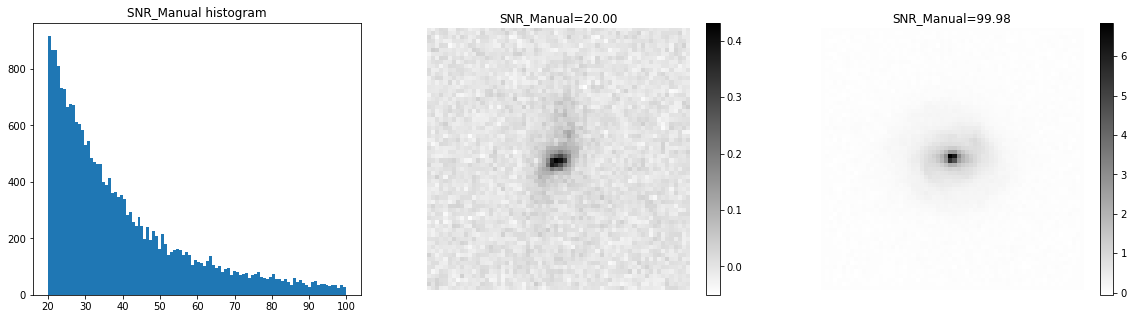

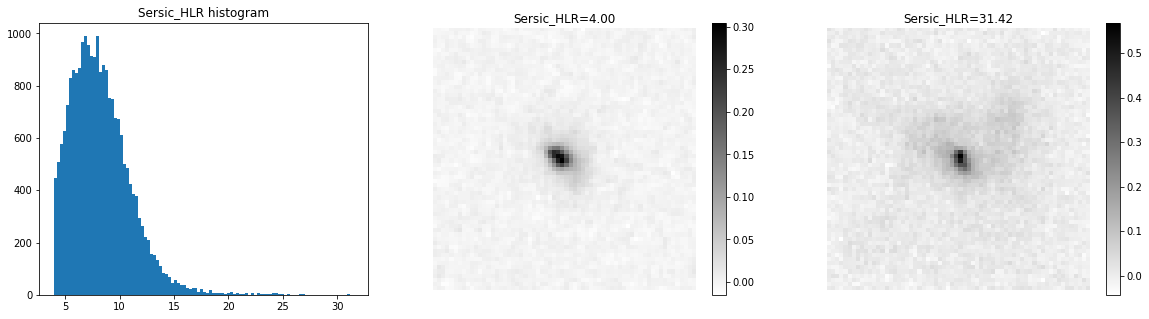

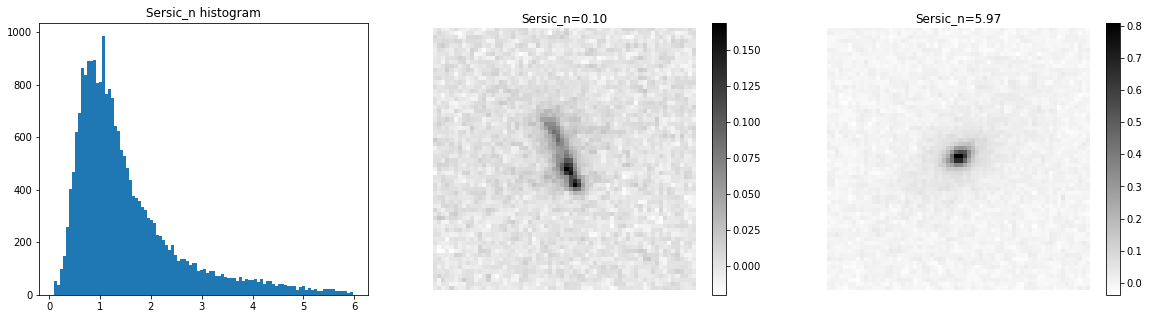

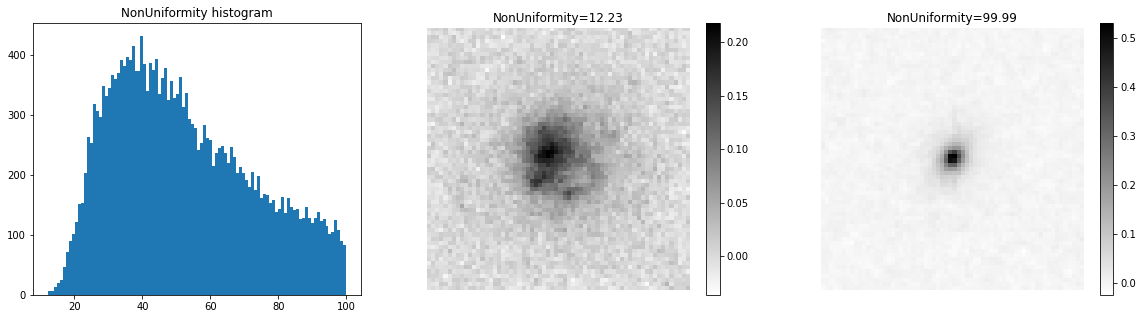

In [54]:
Show_stats(galaxies,df_filtered,'SNR_Manual')
Show_stats(galaxies,df_filtered,'Sersic_HLR')
Show_stats(galaxies,df_filtered,'Sersic_n')
Show_stats(galaxies,df_filtered,'NonUniformity')